## 从安然公司邮件中识别欺诈行为

### 项目概述

在2000年,安然公司是美国最大的公司之一。到2002时，由于广泛的公司欺诈，它已崩溃到破产中。在由此产生的联邦调查中，有相当数量机密信息进入公众眼前，包括成千上万的电子邮件和详细的财务数据。安然欺诈案是一个混乱而又引人入胜的大事件，从中可以发现几乎所有想像得到的企业违法行为。

在这个项目中，我将使用Python机器学习库：[scikit-learn](http://scikit-learn.org/) 和安然电子邮件和财务数据，来建立模型，识别欺诈行为。

本项目将运用到以下知识：
- 特征缩放和特征选择
- 

### 数据集基本信息

聚合的安然电子邮件和财务数据集被存储到字典中，字典中的每个键是一个人名，而且值是包含此人所有特征的一个字典。

In [39]:
import pickle
from feature_format import featureFormat
data_dict = pickle.load(open('./data/final_project_dataset.pkl', 'rb'))
print("The number of people:", len(data_dict))
print("The number of feature:", len(data_dict["SKILLING JEFFREY K"]))

poi = 0
for key, value in data_dict.items():
    if data_dict[key]["poi"] == 1:
        poi += 1
print("How many POI?", poi)

The number of people: 146
The number of feature: 21
How many POI? 18


原始数据集包含146条记录（人），14个财务数据特征，6个电子邮件特征，1个类标号（POI）；一共有18人被标记为嫌疑人（POI）

原数据集为字典类型，python字典不能直接读入到sklearn分类或回归算法中，我编写了一些辅助函数`featureFormat()`，它可以获取特征名的列表和数据字典，然后返回`numpy`数组,如果特征没有某个特定人员的值(即NaN)，此函数还会用 0替换特征值。

In [40]:
import pandas as pd
features_list = ['total_payments', 'deferral_payments', 'long_term_incentive', 'loan_advances', 'from_poi_to_this_person', \
            'from_messages', 'exercised_stock_options', 'total_stock_value', 'director_fees', 'shared_receipt_with_poi',\
            'bonus', 'restricted_stock', 'poi', 'from_this_person_to_poi', 'other', 'salary', 'restricted_stock_deferred',\
            'deferred_income', 'to_messages', 'expenses']
enron_data = featureFormat(data_dict, features_list)
df = pd.DataFrame(enron_data, columns=features)
df.head()

,total_payments,deferral_payments,long_term_incentive,loan_advances,from_poi_to_this_person,from_messages,exercised_stock_options,total_stock_value,director_fees,shared_receipt_with_poi,bonus,restricted_stock,poi,from_this_person_to_poi,other,salary,restricted_stock_deferred,deferred_income,to_messages,expenses
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,189518.0,0.0,0.0,0.0,662086.0,0.0,0.0,0.0,0.0,-472568.0,0.0,0.0,0.0
1,1490344.0,27610.0,0.0,0.0,240.0,40.0,0.0,698242.0,0.0,1132.0,1200000.0,698242.0,1.0,11.0,101740.0,288542.0,0.0,-144062.0,1758.0,16514.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,98784.0,0.0,0.0,32460.0,0.0,0.0,0.0,0.0,-32460.0,-98784.0,0.0,0.0
3,618850.0,0.0,180250.0,0.0,4.0,59.0,0.0,659249.0,0.0,233.0,250000.0,659249.0,0.0,0.0,427316.0,187922.0,0.0,-485813.0,383.0,59175.0
4,111529.0,0.0,0.0,0.0,204.0,221.0,7509039.0,7890324.0,0.0,1063.0,0.0,381285.0,0.0,49.0,0.0,96840.0,0.0,0.0,1671.0,14689.0


### 数据探索

首先，我选择了工资(salary)和奖金(bonus)两个特征（其他特征意义不太明了，且为0的较多，所有这里只观察这两个特征）。

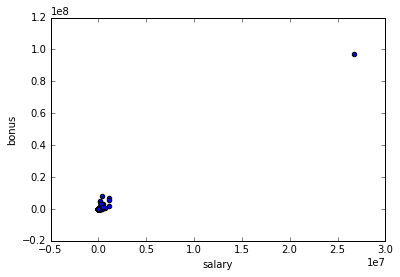

In [41]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.scatter(df['salary'], df['bonus'])
plt.xlabel("salary")
plt.ylabel("bonus")
plt.show()

显然，我们可以发现：右上角的点远离其他那些聚集在一起在左下角的数据点。查询数据集后，发现把**TOTAL**也当做了一名员工，事实上，**TOTAL**是各个财务特征的总和。于是去除该异常值。

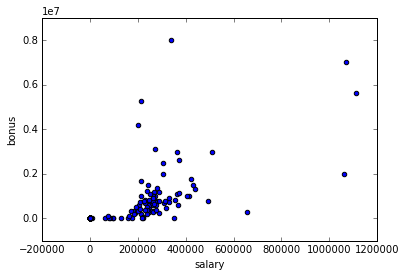

In [43]:
# 去除异常值
outliers = []
for i, val in enumerate(df['salary']):
    outliers.append((i, val))

outliers = sorted(outliers, key=lambda x:x[1], reverse=True)[:1]
for i, val in outliers:
    df = df.drop(i)
    
plt.scatter(df['salary'], df['bonus'])
plt.xlabel("salary")
plt.ylabel("bonus")
plt.show()

去除异常值后，虽然还一些其他点的值非常大，但它们是有效的数据点，可能表明一些差异在POI和non-POI，所有保留这几个数据点。

### 特征选择

凭直觉，特征**from this person to poi**和**this person from poi**，应该与是否为POI和有关系，于是画出这两个特征的散点图：

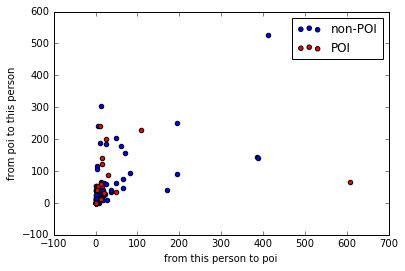

In [44]:
# 画出'from_this_person_to_poi', 'from_poi_to_this_person'散点图
plt.scatter(df['from_this_person_to_poi'][df['poi'] == 0], df['from_poi_to_this_person'][df['poi'] == 0], c='b', label="non-POI")
plt.scatter(df['from_this_person_to_poi'][df['poi'] == 1], df['from_poi_to_this_person'][df['poi'] == 1], c='r', label="POI")
plt.legend(loc='upper right')
plt.xlabel('from this person to poi')
plt.ylabel('from poi to this person')
plt.show()

但是从绘制出的散点图来看，特征**from this person to poi**和**this person from poi**并没有很强关系可以挖掘，以区分是否为POI。于是，创建两个新特征**fraction_from_poi_email**和**fraction_to_poi_email**，分别代表来自POI的电子邮件数占总收到的电子邮件数的比例、发生给POI的电子邮件数占总发送电子邮件数的比例：

In [45]:
# 创建两个新特征
df['fraction_from_poi_email'] = 0
df['fraction_to_poi_email'] = 0

df.loc[:, 'fraction_from_poi_email'] = df.loc[:, 'from_poi_to_this_person'] / df.loc[:, 'to_messages']
df.loc[:, 'fraction_to_poi_email'] = df.loc[:, 'from_this_person_to_poi'] / df.loc[:, 'from_messages']

df.fillna(0, inplace=True)

df.head()

,total_payments,deferral_payments,long_term_incentive,loan_advances,from_poi_to_this_person,from_messages,exercised_stock_options,total_stock_value,director_fees,shared_receipt_with_poi,...,poi,from_this_person_to_poi,other,salary,restricted_stock_deferred,deferred_income,to_messages,expenses,fraction_from_poi_email,fraction_to_poi_email
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,189518.0,0.0,0.0,...,0.0,0.0,0.0,0.0,-472568.0,0.0,0.0,0.0,0.000000,0.000000
1,1490344.0,27610.0,0.0,0.0,240.0,40.0,0.0,698242.0,0.0,1132.0,...,1.0,11.0,101740.0,288542.0,0.0,-144062.0,1758.0,16514.0,0.136519,0.275000
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,98784.0,0.0,...,0.0,0.0,0.0,0.0,-32460.0,-98784.0,0.0,0.0,0.000000,0.000000
3,618850.0,0.0,180250.0,0.0,4.0,59.0,0.0,659249.0,0.0,233.0,...,0.0,0.0,427316.0,187922.0,0.0,-485813.0,383.0,59175.0,0.010444,0.000000
4,111529.0,0.0,0.0,0.0,204.0,221.0,7509039.0,7890324.0,0.0,1063.0,...,0.0,49.0,0.0,96840.0,0.0,0.0,1671.0,14689.0,0.122083,0.221719


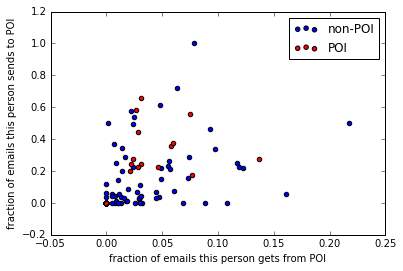

In [46]:
# 可视化新特征
plt.scatter(df['fraction_from_poi_email'][df['poi'] == 0], df['fraction_to_poi_email'][df['poi'] == 0], c='b', label="non-POI")
plt.scatter(df['fraction_from_poi_email'][df['poi'] == 1], df['fraction_to_poi_email'][df['poi'] == 1], c='r', label="POI")
plt.legend(loc='upper right')
plt.xlabel('fraction of emails this person gets from POI')
plt.ylabel('fraction of emails this person sends to POI')
plt.show()

从这个新的散点图，我们似乎可以发现红色的数据点（POI）聚集在散点图的中心

In [50]:
features = df.drop(['poi'], axis=1)
labels = df.loc[:, 'poi']

In [68]:
features_list = ['total_payments', 'deferral_payments', 'long_term_incentive', 'loan_advances', 'from_poi_to_this_person', \
            'from_messages', 'exercised_stock_options', 'total_stock_value', 'director_fees', 'shared_receipt_with_poi',\
            'bonus', 'restricted_stock', 'from_this_person_to_poi', 'other', 'salary', 'restricted_stock_deferred',\
            'deferred_income', 'to_messages', 'expenses', 'fraction_from_poi_email', 'fraction_to_poi_email']

使用[Tree-based feature selection](http://scikit-learn.org/stable/modules/feature_selection.html#tree-based-feature-selection)计算出个特征的重要性

In [94]:
from sklearn.ensemble import ExtraTreesClassifier
clf = ExtraTreesClassifier()
clf = clf.fit(features, labels)
importances = clf.feature_importances_
impfeat = []
for i in range(21):
    impfeat.append((features_list[i], importances[i]))

impfeat.sort(key=lambda x:x[1], reverse=True)
print(impfeat)

[('total_stock_value', 0.11015467414214634), ('exercised_stock_options', 0.083663364574373247), ('deferred_income', 0.080289714600270373), ('fraction_to_poi_email', 0.074632008765518065), ('restricted_stock', 0.068360397990349528), ('expenses', 0.067744381674889678), ('bonus', 0.066120783121517632), ('shared_receipt_with_poi', 0.062698024088307963), ('other', 0.058634490259551489), ('total_payments', 0.054193954851614046), ('salary', 0.045539354510978493), ('from_this_person_to_poi', 0.043774618443622536), ('fraction_from_poi_email', 0.041807936861384565), ('from_poi_to_this_person', 0.041617154926070189), ('to_messages', 0.031422857142857141), ('long_term_incentive', 0.021641046594982064), ('deferral_payments', 0.018516244587307901), ('from_messages', 0.01675517096205268), ('loan_advances', 0.0073582129653635949), ('restricted_stock_deferred', 0.0035164069952305205), ('director_fees', 0.0015592019416119324)]


In [98]:
# 选取重要性最大的8个特征
features_list = ['total_stock_value', 'exercised_stock_options', 'deferred_income', 'fraction_to_poi_email', \
                 'restricted_stock', 'expenses', 'bonus', 'shared_receipt_with_poi']

features = df.loc[:, features_list]
labels = df.loc[:, 'poi']

### Algorithm Selection

In [99]:
from sklearn.cross_validation import train_test_split
features_train, features_test, labels_train, labels_test = train_test_split(features, labels, test_size=0.3, random_state=42)

,total_stock_value,exercised_stock_options,deferred_income,fraction_to_poi_email,restricted_stock,expenses,bonus,shared_receipt_with_poi
118,139130.0,139130.0,0.0,0.000000,0.0,0.0,0.0,0.0
19,0.0,0.0,-36666.0,0.000000,0.0,228656.0,0.0,0.0
83,955873.0,493489.0,0.0,0.000000,462384.0,0.0,0.0,22.0
98,698920.0,0.0,0.0,0.342105,698920.0,0.0,700000.0,2565.0
56,2072035.0,1441898.0,0.0,0.030959,630137.0,178979.0,2000000.0,1730.0


In [111]:
from time import time
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score
clf = LogisticRegression()

t0 = time()
clf.fit(features_train, labels_train)
print("training time:", round(time()-t0, 3), "s")

t1 = time()
pred = clf.predict(features_test)
print("testing time:", round(time()-t1, 3), "s")

print("Accuracy: ", accuracy_score(labels_test, pred))
print("Precision: ", precision_score(labels_test, pred))
print("Recall: ", recall_score(labels_test, pred))

training time: 0.002 s
testing time: 0.0 s
Accuracy:  0.813953488372
Precision:  0.125
Recall:  0.5


In [112]:
from sklearn.naive_bayes import GaussianNB
clf = GaussianNB()

t0 = time()
clf.fit(features_train, labels_train)
print("training time:", round(time()-t0, 3), "s")

t1 = time()
pred = clf.predict(features_test)
print("testing time:", round(time()-t1, 3), "s")

print("Accuracy: ", accuracy_score(labels_test, pred))
print("Precision: ", precision_score(labels_test, pred))
print("Recall: ", recall_score(labels_test, pred))

training time: 0.002 s
testing time: 0.001 s
Accuracy:  0.906976744186
Precision:  0.25
Recall:  0.5


In [150]:
from sklearn import tree
clf = tree.DecisionTreeClassifier()

t0 = time()
clf.fit(features_train, labels_train)
print("training time:", round(time()-t0, 3), "s")

t1 = time()
pred = clf.predict(features_test)
print("testing time:", round(time()-t1, 3), "s")

print("Accuracy: ", accuracy_score(labels_test, pred))
print("Precision: ", precision_score(labels_test, pred))
print("Recall: ", recall_score(labels_test, pred))

training time: 0.001 s
testing time: 0.0 s
Accuracy:  0.906976744186
Precision:  0.0
Recall:  0.0


In [117]:
from sklearn.neighbors import KNeighborsClassifier
clf = KNeighborsClassifier()

t0 = time()
clf.fit(features_train, labels_train)
print("training time:", round(time()-t0, 3), "s")

t1 = time()
pred = clf.predict(features_test)
print("testing time:", round(time()-t1, 3), "s")

print("Accuracy: ", accuracy_score(labels_test, pred))
print("Precision: ", precision_score(labels_test, pred))
print("Recall: ", recall_score(labels_test, pred))

training time: 0.001 s
testing time: 0.001 s
Accuracy:  0.953488372093
Precision:  0.5
Recall:  0.5
